In [21]:
# Rogue AP detection as Anomaly with SVM
# André L. S. Paula / Eduardo K. Viegas / Altair O. Santim

# SVM

# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM, SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc
from sklearn import utils
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Selection dataset / features
df_orig = pd.read_csv('/content/drive/MyDrive/datasets/amostra.csv')


In [23]:
relevant_features = ['rogue', 'Dot11EltCountry', 'RSNVersion', 'rates',
       'CapabilitiesMin_MPDCU_Start_Spacing', 'DSSS_CCK', 'Max_A_MSDU',
       'Rx_STBC', 'Tx_STBC', 'Short_GI_40Mhz', 'Short_GI_20Mhz',
       'SM_Power_Save', 'Supported_Channel_Width', 'LDPC_Coding_Capability',
       'Min_MPDCU_Start_Spacing', 'Max_A_MPDU_Length_Exponent',
       'TX_MCS_Set_Defined', 'RX_MSC_Bitmask',
       'Compressed_Steering_n_Beamformer_Antennas_Supported', 'Receive_NDP',
       'entropy']

data = df_orig[relevant_features]
df_orig.shape

(357, 21)

In [24]:
# Count RogueAP in dataset
data['rogue'].value_counts()

rogue
 1    186
-1    171
Name: count, dtype: int64

In [25]:
# class 1 (normal): data['rogue'] == 1 ]
# class -1 (attack): data['rogue'] == -1 ]
target = data['rogue']

# Outliers
outliers = target[target == -1]
print("outliers.shape", outliers.shape)
print("outlier fraction", outliers.shape[0]/target.shape[0])

# Features without target (rogue)
data.drop(["rogue"], axis=1, inplace=True)

# check data shape
data.shape

outliers.shape (171,)
outlier fraction 0.4789915966386555


(357, 20)

In [26]:
# Test and train dataset selection
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)
train_data.shape

(285, 20)

In [27]:
nu = outliers.shape[0] / target.shape[0]
print("nu", nu)

nu 0.4789915966386555


In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(train_data)

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, train_target)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.87


In [29]:
# Applying SVM
model_SVM = SVC(C=1.0, gamma=1.0)
y_score_svm = model_SVM.fit(train_data, train_target)
y_pred_svm = model_SVM.decision_function(train_data)

In [30]:
# Identifying the metrics from Train SVM
preds_SVM = model_SVM.predict(train_data)
targs_SVM = train_target

print("accuracy: ", metrics.accuracy_score(targs_SVM, preds_SVM))
print("precision: ", metrics.precision_score(targs_SVM, preds_SVM))
print("recall: ", metrics.recall_score(targs_SVM, preds_SVM))
print("f1: ", metrics.f1_score(targs_SVM, preds_SVM))
print("area under curve (auc): ", metrics.roc_auc_score(targs_SVM, preds_SVM))


accuracy:  0.9333333333333333
precision:  0.9125
recall:  0.9668874172185431
f1:  0.9389067524115755
area under curve (auc):  0.9312049026391224


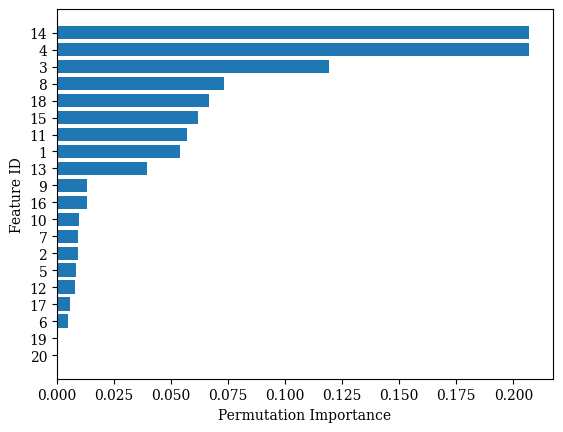

In [31]:
# Ganho de informação SVM with RBF
%matplotlib inline
perm_importance = permutation_importance(model_SVM, train_data, train_target)
feature_names = relevant_features = ['1', '2', '3','4', '5', '6','7', '8', '9', '10', '11', '12', '13','14', '15','16', '17','18', '19','20']
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature ID")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

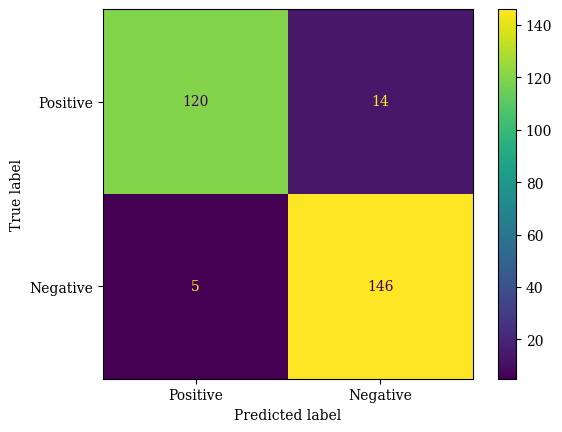

In [32]:
# Confuion Matrix SVM
MatrizConfusao2 = confusion_matrix(targs_SVM,preds_SVM)
ConfusionMatrixDisplay(confusion_matrix(targs_SVM,preds_SVM),display_labels=['Positive','Negative']).plot()
plt.plot(title="SVM")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

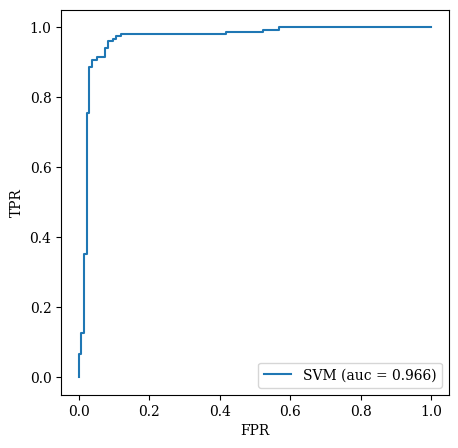

In [33]:
from sklearn.metrics import roc_curve, auc

svm_fpr, svm_tpr, threshold = roc_curve(train_target, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.legend()
plt.show()

In [34]:
# Applying SVM
# Identifying the metrics from Test (Predict)
preds_SVM = model_SVM.predict(test_data)
targs_SVM = test_target

print("accuracy: ", metrics.accuracy_score(targs_SVM, preds_SVM))
print("precision: ", metrics.precision_score(targs_SVM, preds_SVM))
print("recall: ", metrics.recall_score(targs_SVM, preds_SVM))
print("f1: ", metrics.f1_score(targs_SVM, preds_SVM))
#print("area under curve (auc): ", metrics.roc_auc_score(targs_SVM, preds_SVM))

accuracy:  0.8472222222222222
precision:  0.7857142857142857
recall:  0.9428571428571428
f1:  0.8571428571428571


[]

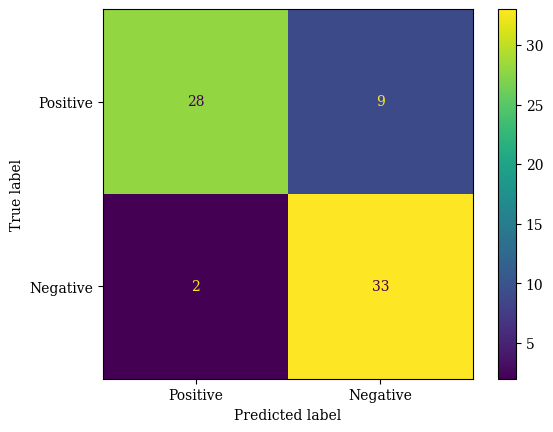

In [35]:
# Confusion Matrix SVM
MatrizConfusao2 = confusion_matrix(targs_SVM,preds_SVM)
ConfusionMatrixDisplay(confusion_matrix(targs_SVM,preds_SVM),display_labels=['Positive','Negative']).plot()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.plot(title="SVM")

In [36]:
outlier_index=list(outliers.index)
print(outlier_index)

[1, 4, 6, 7, 9, 11, 13, 15, 16, 18, 20, 22, 25, 27, 29, 30, 32, 33, 35, 37, 39, 41, 43, 45, 47, 50, 54, 56, 58, 61, 62, 65, 68, 71, 72, 75, 76, 77, 81, 83, 84, 86, 87, 89, 91, 93, 95, 96, 98, 100, 102, 103, 104, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 128, 130, 133, 134, 142, 146, 148, 150, 153, 154, 156, 158, 160, 161, 162, 164, 166, 168, 170, 171, 173, 176, 177, 180, 181, 183, 187, 189, 192, 193, 196, 197, 199, 202, 203, 205, 208, 210, 211, 212, 215, 216, 218, 220, 222, 225, 226, 229, 230, 232, 233, 236, 237, 238, 240, 242, 245, 247, 249, 251, 253, 255, 258, 259, 260, 263, 264, 266, 268, 270, 271, 272, 275, 276, 277, 279, 282, 283, 286, 288, 290, 292, 294, 296, 302, 314, 316, 318, 320, 322, 324, 326, 328, 329, 331, 333, 335, 339, 341, 342, 345, 346, 348, 351, 352, 354, 356]


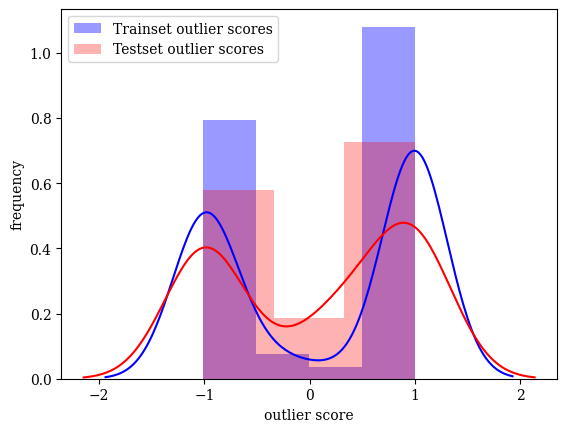

In [38]:
outlier_scores_train = model_SVM.decision_function(train_data)
outlier_scores_test  = model_SVM.decision_function(test_data)

train_df = pd.concat([train_data.reset_index(drop=True), pd.DataFrame(outlier_scores_train, columns=["outlier score"])], axis=1)
test_df = pd.concat([test_data.reset_index(drop=True), pd.DataFrame(outlier_scores_test, columns=["outlier score"])], axis=1)

sns.distplot(outlier_scores_train, kde=True, norm_hist=True, color="b", label="Trainset outlier scores")
sns.distplot(outlier_scores_test,  kde=True, norm_hist=True, color="r", label="Testset outlier scores", hist_kws={'alpha': 0.3})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.xlabel("outlier score")
plt.ylabel("frequency")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.legend()
plt.show()

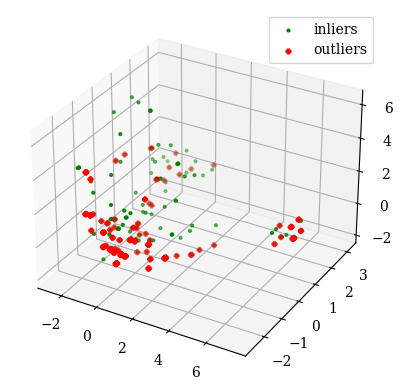

In [40]:
# Visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(data)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=4, s=4, marker="x", c="red", label="outliers")
ax.legend()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.show()